In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

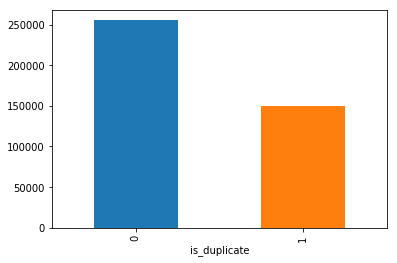

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



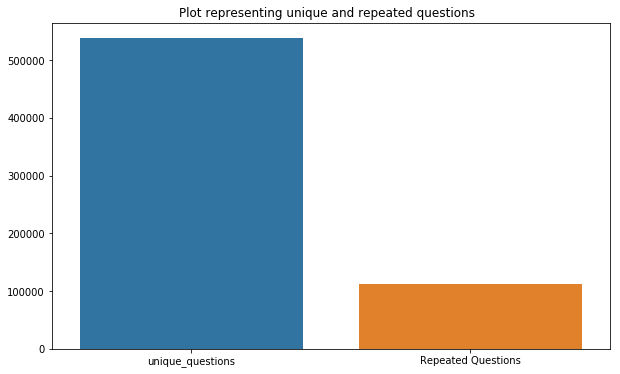

In [9]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



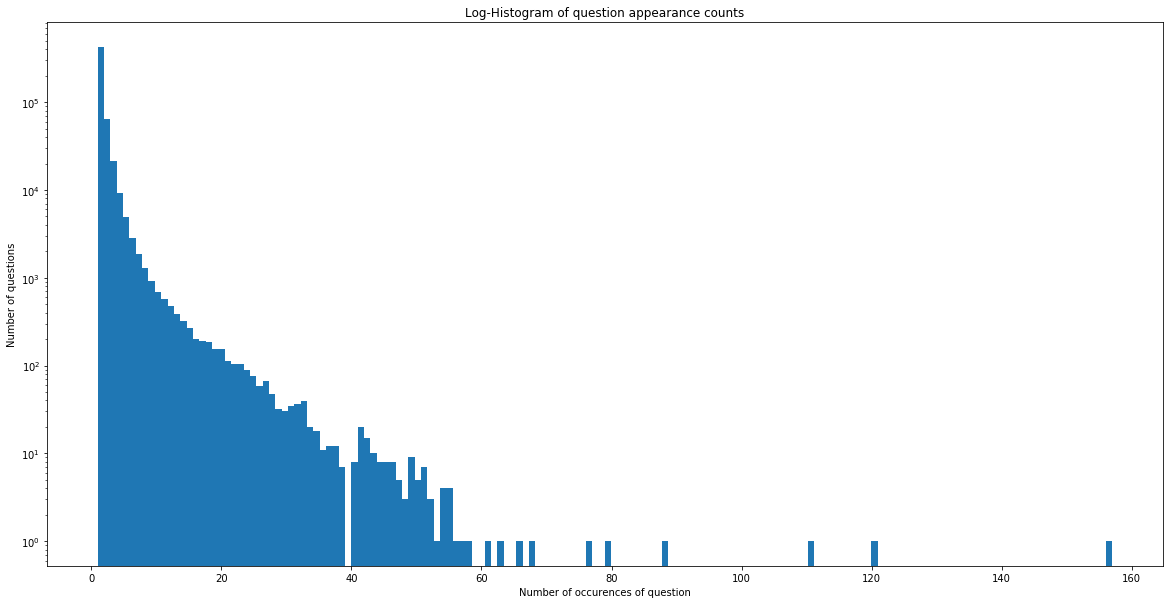

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [12]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [13]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

In [14]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [15]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

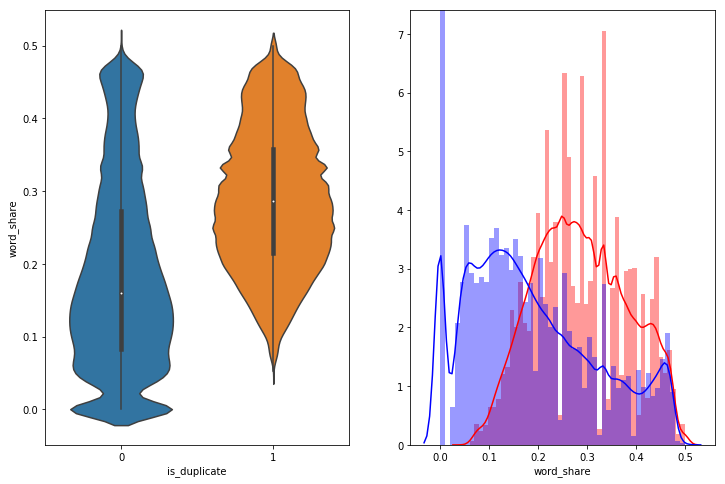

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

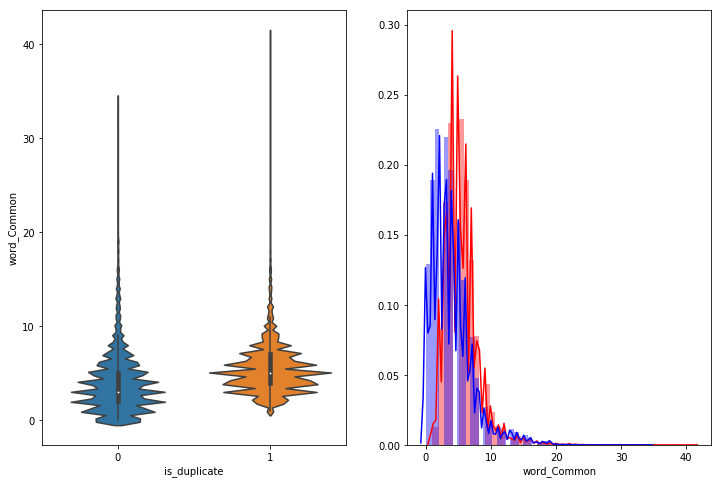

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [18]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [19]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [ ]:
#Preprocessing of Text 

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [2]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

In [21]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [27]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [23]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [24]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

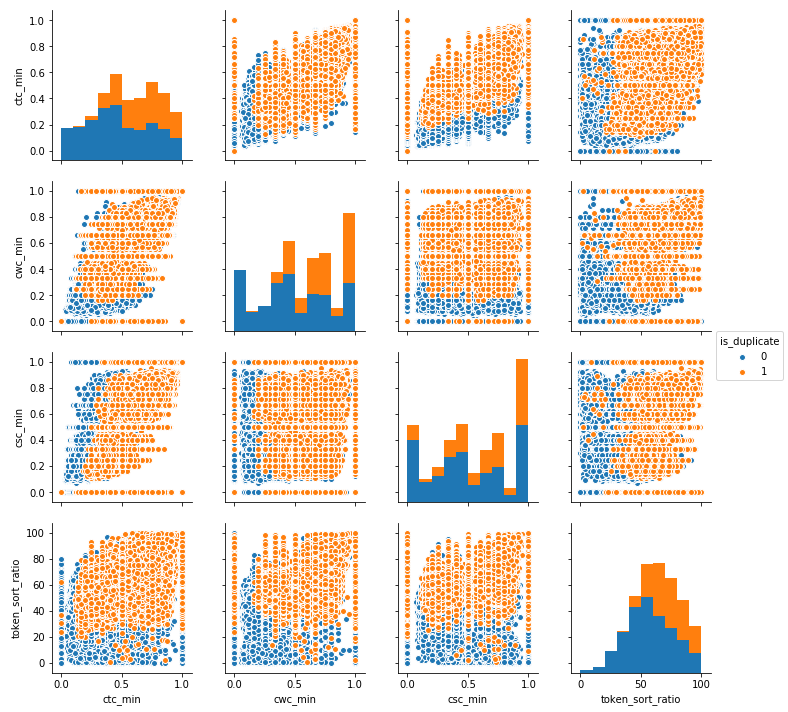

In [27]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

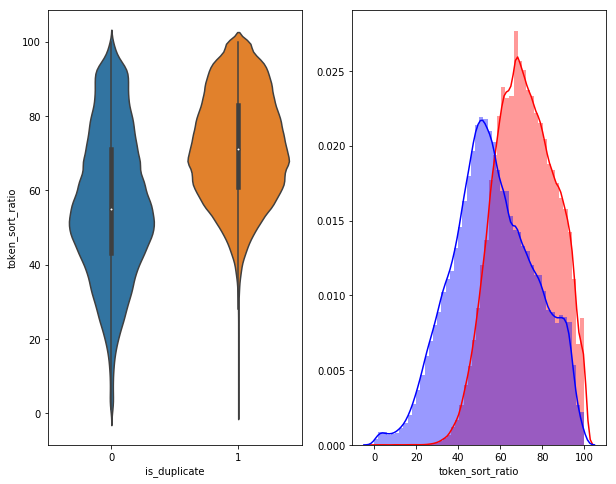

In [28]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

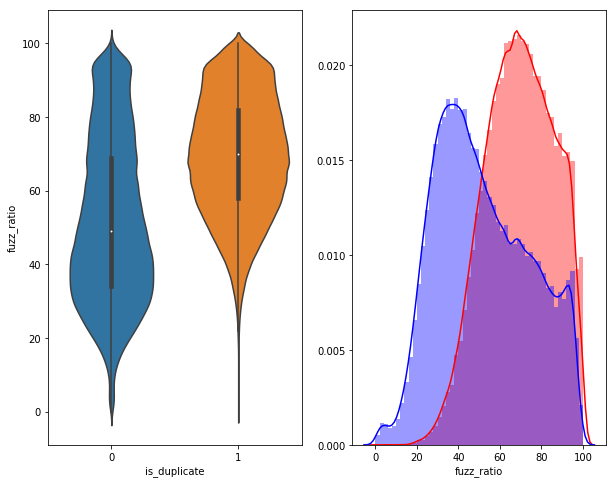

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [30]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [31]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.304s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.310s
[t-SNE] Iteration 50: error = 81.2897949, gradient norm = 0.0455700 (50 iterations in 3.856s)
[t-SNE] Iteration 100: error = 70.6164398, gradient norm = 0.0095177 (50 iterations in 3.056s)
[t-SNE] Iteration 150: error = 68.9172134, gradient norm = 0.0056736 (50 iterations in 2.977s)
[t-SNE] Iteration 200: error = 68.1004639, gradient norm = 0.0049672 (50 iterations in 3.045s)
[t-SNE] Iteration 250: error = 67.5914536, gradient norm = 0.0039700

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

import spacy

In [3]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [4]:
import en_core_web_sm

In [7]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [51:03<00:00, 131.95it/s]


In [8]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [51:38<00:00, 130.49it/s]


In [9]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [10]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [11]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [12]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [13]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,121.929942,100.083880,72.497911,115.641811,-48.370869,34.619061,-172.057791,-92.502620,113.223269,50.562425,...,12.397645,40.909527,8.150259,-15.170695,18.007704,6.167002,-30.124162,3.700891,-1.757701,-1.818054
1,-78.070951,54.843758,82.738470,98.191843,-51.234829,55.013499,-39.140743,-82.692363,45.161478,-9.556312,...,-21.987076,-12.389276,20.667988,2.202712,-17.142450,-5.880969,-10.123960,-4.890663,-13.018387,-5.219299
2,-5.355038,73.671822,14.376389,104.130229,1.433505,35.229101,-148.519386,-97.124609,41.972183,50.948724,...,3.027701,14.025776,-2.960310,-3.206542,4.355143,2.936156,-20.199560,9.816350,11.894365,-8.798817
3,5.778357,-34.712029,48.999641,59.699237,40.661264,-41.658736,-36.808583,24.170647,0.235591,-29.407297,...,13.100011,1.405662,-1.891074,-7.882639,18.000562,12.106919,-10.507836,5.243826,10.158344,5.886345
4,51.138244,38.587245,123.639505,53.333045,-47.062794,37.356188,-298.722757,-106.421101,106.248917,65.880708,...,13.906532,43.461717,11.519202,-22.468288,45.431128,8.161224,-35.373911,7.728860,9.592854,5.447332


In [14]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,125.983298,95.636470,42.114726,95.450003,-37.386298,39.400067,-148.116056,-87.851470,110.371952,62.272808,...,16.165598,33.030675,7.019995,-14.793956,15.437508,8.199661,-25.070837,1.571609,1.603732,0.305657
1,-106.871918,80.290394,79.066295,59.302086,-42.175396,117.616721,-144.364294,-127.131529,22.962535,25.397595,...,-4.901131,-4.565384,41.520752,-0.727562,-16.413774,-7.373776,2.638878,-7.403461,2.703065,0.408052
2,7.072902,15.513379,1.846908,85.937593,-33.808806,94.702355,-122.256852,-114.009528,53.922329,60.131812,...,8.359975,-2.165974,10.936577,-16.531654,14.681221,15.633755,-1.210893,14.183818,11.703130,10.148080
3,39.421524,44.136999,-24.010940,85.265890,-0.339027,-9.323140,-60.499645,-37.044788,49.407829,-23.350167,...,3.311411,3.788880,13.398604,-6.592597,6.437358,5.993291,2.732391,-3.727645,5.614124,6.023692
4,31.950129,62.854121,1.778174,36.218745,-45.130847,66.674900,-106.342323,-22.901015,59.835930,62.663936,...,-2.403874,11.991198,8.088481,-15.090199,8.375162,1.727222,-6.601128,11.317407,11.544598,2.478690


In [15]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 384
Number of features in question2 w2v  dataframe : 384
Number of features in final dataframe  : 797


In [16]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [7]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [8]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.999980000399992,0.8333194446759221,0.9999833336111064,0.9999833336111064,0.9166590278414348,0.7857086735094749,0.0,1.0,2.0,13.0,...,16.165598386898637,33.03067463636398,7.019995227456093,-14.793955877423286,15.437508314847946,8.19966059923172,-25.070836670696735,1.5716093145310879,1.6037320122122765,0.3056571036577225
2,0.7999840003199936,0.3999960000399996,0.7499812504687383,0.5999880002399952,0.6999930000699993,0.4666635555762962,0.0,1.0,5.0,12.5,...,-4.901130557060242,-4.565384194254875,41.5207524523139,-0.7275624666363001,-16.41377378255129,-7.373775810003281,2.638877835124731,-7.403460711240768,2.7030646055936813,0.4080522954463959
3,0.3999920001599968,0.3333277778703688,0.3999920001599968,0.24999687503906198,0.3999960000399996,0.28571224491253633,0.0,1.0,4.0,12.0,...,8.359974771738052,-2.165974423289299,10.936577022075653,-16.53165421076119,14.681220807135105,15.63375510275364,-1.2108925580978394,14.183817744255066,11.703129768371582,10.148079725913703
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,...,3.31141060590744,3.788880407810211,13.398604452610016,-6.592596508562565,6.437358126044273,5.993290975689888,2.7323912382125854,-3.7276453971862793,5.614123735576868,6.023691833019257
5,0.3999920001599968,0.19999800001999984,0.9999500024998748,0.6666444451851604,0.5714204082798817,0.3076899408466089,0.0,1.0,6.0,10.0,...,-2.4038737677037716,11.99119820445776,8.088481079787016,-15.09019909799099,8.375162452459335,1.7272223234176636,-6.601127505302429,11.317407250404358,11.544598042964935,2.4786900877952576


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 1 to 404290
Columns: 794 entries, cwc_min to 383_y
dtypes: object(794)
memory usage: 2.4+ GB


In [10]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)

In [11]:
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [12]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3,random_state=13)

In [13]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 794)
Number of data points in test data : (121287, 794)


In [14]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8876992330072402


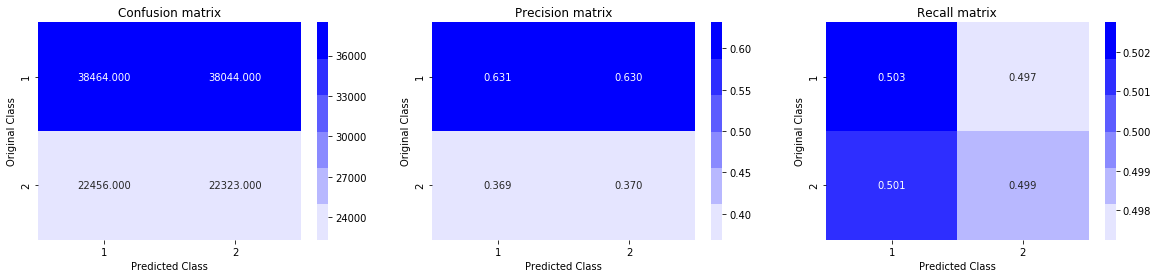

In [33]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5050464987596055
For values of alpha =  0.0001 The log loss is: 0.5156064161083074
For values of alpha =  0.001 The log loss is: 0.5118124206289113
For values of alpha =  0.01 The log loss is: 0.5215407246451201
For values of alpha =  0.1 The log loss is: 0.49485550469453093
For values of alpha =  1 The log loss is: 0.47346295882439915
For values of alpha =  10 The log loss is: 0.5062282696956512


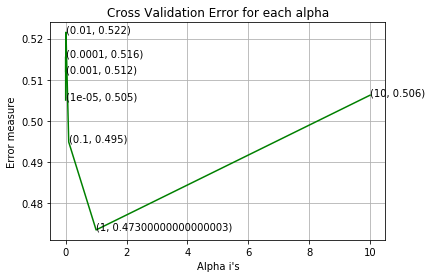

For values of best alpha =  1 The train log loss is: 0.4712558809818194
For values of best alpha =  1 The test log loss is: 0.47346295882439915
Total number of data points : 121287


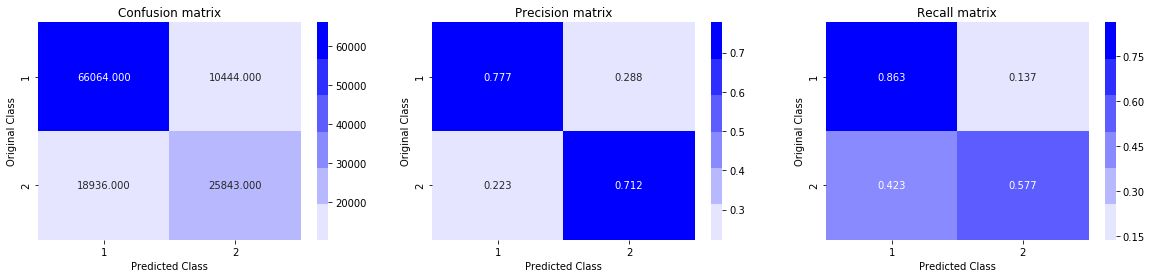

In [16]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

SGD is sensitive to feature scaling, so did scaling and tried.

In [17]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_sc = scale.fit_transform(X_train)
X_test_sc = scale.transform(X_test)

For values of alpha =  1e-05 The log loss is: 0.45683456744359
For values of alpha =  0.0001 The log loss is: 0.45492081462801304
For values of alpha =  0.001 The log loss is: 0.40559361222633294
For values of alpha =  0.01 The log loss is: 0.40761367674333254
For values of alpha =  0.1 The log loss is: 0.44362792720222327
For values of alpha =  1 The log loss is: 0.5000580130072036
For values of alpha =  10 The log loss is: 0.5704629435817549


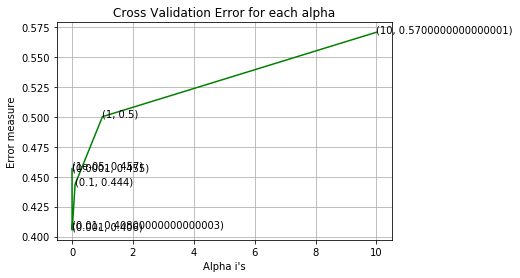

For values of best alpha =  0.001 The train log loss is: 0.4031443854177573
For values of best alpha =  0.001 The test log loss is: 0.40559361222633294
Total number of data points : 121287


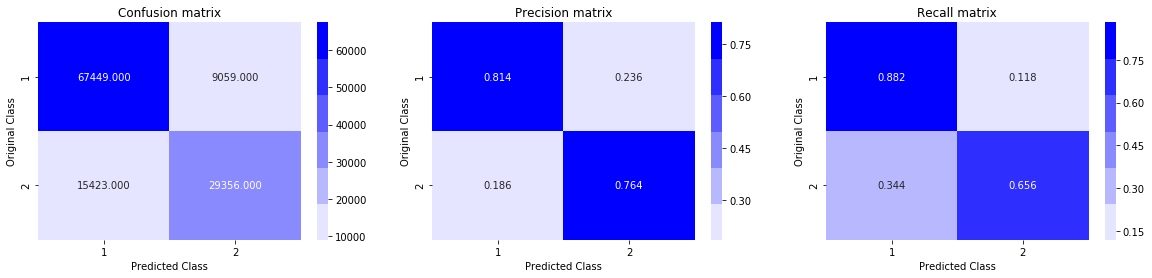

In [39]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  0.000862 The log loss is: 0.4075498397239791
For values of alpha =  0.001017 The log loss is: 0.40539250011035743
For values of alpha =  0.001226 The log loss is: 0.4034425566208746
For values of alpha =  0.001482 The log loss is: 0.4019625978302733
For values of alpha =  0.00212 The log loss is: 0.40043503086001114
For values of alpha =  0.003 The log loss is: 0.40034152313699967
For values of alpha =  0.00314 The log loss is: 0.4004166666193004
For values of alpha =  0.003153 The log loss is: 0.4004249565995252
For values of alpha =  0.003568 The log loss is: 0.4007241237416872
For values of alpha =  0.003988 The log loss is: 0.40110250715655493
For values of alpha =  0.004111 The log loss is: 0.4012226624599859
For values of alpha =  0.005223 The log loss is: 0.4024120323437416
For values of alpha =  0.005941 The log loss is: 0.40322094282826937
For values of alpha =  0.00595 The log loss is: 0.4032311500519025


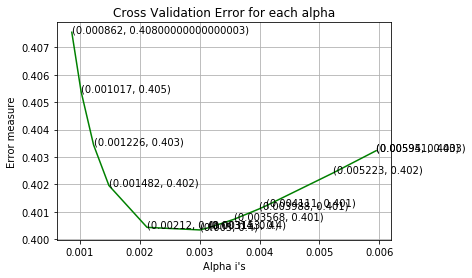

For values of best alpha =  0.003 The train log loss is: 0.39784383489862885
For values of best alpha =  0.003 The test log loss is: 0.40034152313699967
Total number of data points : 121287


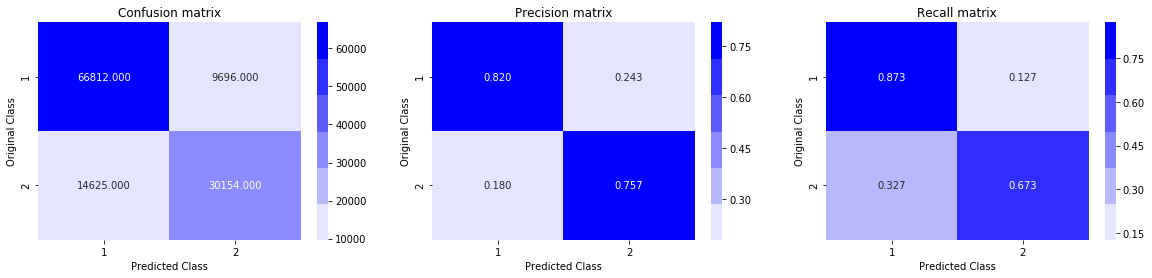

In [51]:
#alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
np.random.seed(45)
alpha = np.random.uniform(0.0006,0.006,14)
alpha = np.round(alpha,6)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.47459282302213923
For values of alpha =  0.0001 The log loss is: 0.46819163734685043
For values of alpha =  0.001 The log loss is: 0.43159379565435446
For values of alpha =  0.01 The log loss is: 0.42292019437911754
For values of alpha =  0.1 The log loss is: 0.5260749681006414
For values of alpha =  1 The log loss is: 0.6585278256322723
For values of alpha =  10 The log loss is: 0.6585278256322611


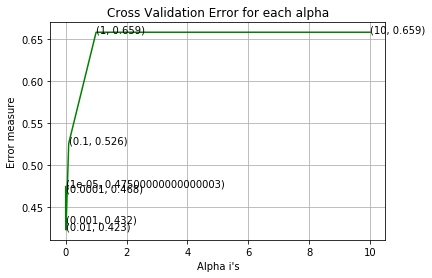

For values of best alpha =  0.01 The train log loss is: 0.4223724082952659
For values of best alpha =  0.01 The test log loss is: 0.42292019437911754
Total number of data points : 121287


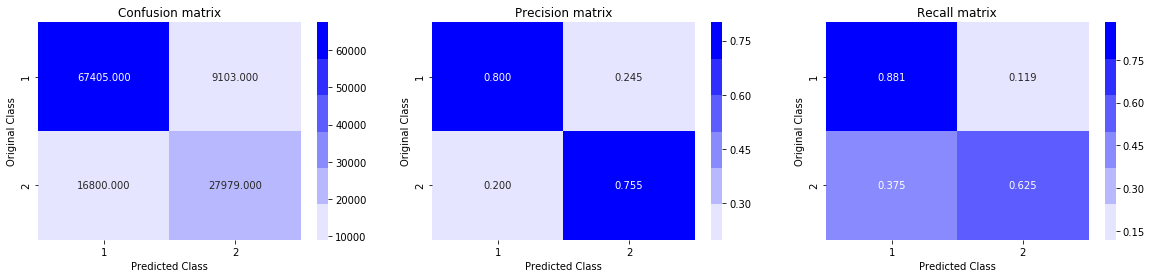

In [56]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.46827517367892096
For values of alpha =  0.0001 The log loss is: 0.45775339387339004
For values of alpha =  0.001 The log loss is: 0.42313495536418577
For values of alpha =  0.01 The log loss is: 0.40541772273229554
For values of alpha =  0.1 The log loss is: 0.4313071929003579
For values of alpha =  1 The log loss is: 0.4730453418766842
For values of alpha =  10 The log loss is: 0.5272789313684569


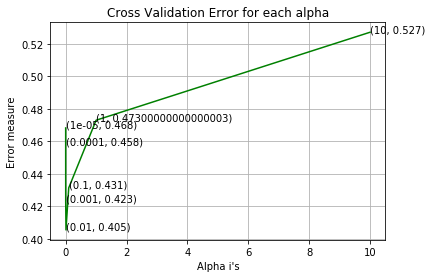

For values of best alpha =  0.01 The train log loss is: 0.4027358236207044
For values of best alpha =  0.01 The test log loss is: 0.40541772273229554
Total number of data points : 121287


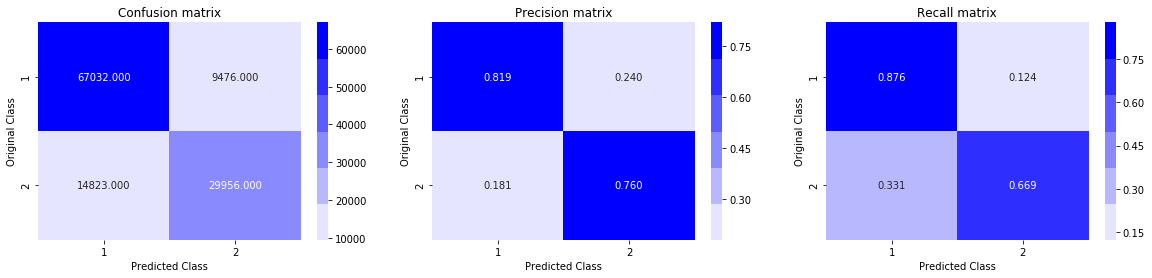

In [57]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  0.00517 The log loss is: 0.4037706351092166
For values of alpha =  0.00529 The log loss is: 0.4036245330070321
For values of alpha =  0.00721 The log loss is: 0.4038591515869226
For values of alpha =  0.00981 The log loss is: 0.4052693810491646
For values of alpha =  0.01228 The log loss is: 0.40630937344731693
For values of alpha =  0.01327 The log loss is: 0.4068733679114762
For values of alpha =  0.01351 The log loss is: 0.4067584415367667
For values of alpha =  0.01425 The log loss is: 0.40712629206352663
For values of alpha =  0.01452 The log loss is: 0.40718224970845057
For values of alpha =  0.01757 The log loss is: 0.40882766620678973
For values of alpha =  0.0183 The log loss is: 0.4091457931830299
For values of alpha =  0.01839 The log loss is: 0.4091050200862671
For values of alpha =  0.02118 The log loss is: 0.41044869825018293
For values of alpha =  0.02636 The log loss is: 0.4126434814409032


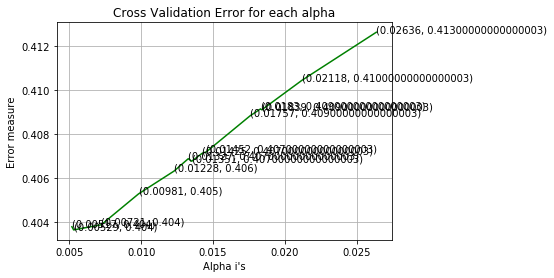

For values of best alpha =  0.00529 The train log loss is: 0.4008580635552486
For values of best alpha =  0.00529 The test log loss is: 0.4036245330070321
Total number of data points : 121287


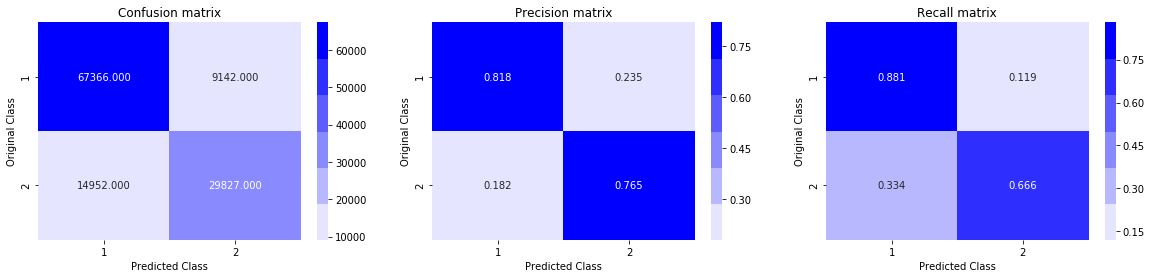

In [63]:
#alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

np.random.seed(25)
alpha = np.random.uniform(0.002,0.03,14)
alpha = np.round(alpha,5)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y,eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y,eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 Random Forest </h2>

In [16]:
from sklearn.ensemble import RandomForestClassifier as RFC

estimators =  100 Train Log Loss  0.11109459647005955 Test Log Loss  0.37192988174912683
estimators =  150 Train Log Loss  0.11100847787606712 Test Log Loss  0.37065163655861083
estimators =  200 Train Log Loss  0.11056444275163889 Test Log Loss  0.3698413672093776
estimators =  300 Train Log Loss  0.11035449276121001 Test Log Loss  0.3690804893102336
estimators =  400 Train Log Loss  0.11047904985310375 Test Log Loss  0.3693838339921741
estimators =  600 Train Log Loss  0.11021203125673375 Test Log Loss  0.36823350864534526
estimators =  800 Train Log Loss  0.11039528102117314 Test Log Loss  0.3688582117860808


Text(0,0.5,'Log Loss')

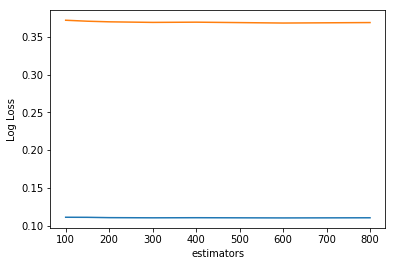

In [19]:
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = RFC(n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators') n  
plt.ylabel('Log Loss')

Depth =  5 Train Log Loss  0.48722729508327145 Test Log Loss  0.48813291311027934
Depth =  10 Train Log Loss  0.4081238487571798 Test Log Loss  0.4225459782185362
Depth =  12 Train Log Loss  0.37408662763549844 Test Log Loss  0.4074103602751899
Depth =  15 Train Log Loss  0.3079064316463802 Test Log Loss  0.38802805760307507
Depth =  20 Train Log Loss  0.20481718757448902 Test Log Loss  0.3743196152422552
Depth =  25 Train Log Loss  0.14326963278706298 Test Log Loss  0.37110604544161335
Depth =  50 Train Log Loss  0.11139277276272488 Test Log Loss  0.3715810469258812


Text(0,0.5,'Log Loss')

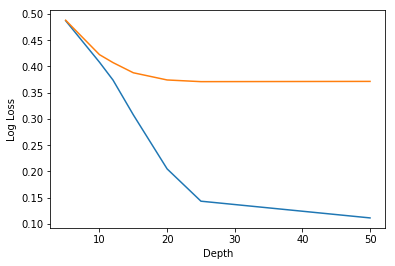

In [19]:
Depth = [5,10,12,15,20,25,50]
test_scores = []
train_scores = []
for i in Depth:
    clf = RFC(n_estimators=100,max_depth=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Depth = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(Depth,train_scores,label='Train Log Loss')
plt.plot(Depth,test_scores,label='Test Log Loss')
plt.xlabel('Depth') 
plt.ylabel('Log Loss')

estimators =  100 Train Log Loss  0.39289057215728057 Test Log Loss  0.4154641445550544
estimators =  150 Train Log Loss  0.3916522623500148 Test Log Loss  0.4145023288788135
estimators =  200 Train Log Loss  0.39088408416850556 Test Log Loss  0.413370659547225
estimators =  300 Train Log Loss  0.39465656231621055 Test Log Loss  0.41716846990811174
estimators =  400 Train Log Loss  0.3913998286278825 Test Log Loss  0.4138491796713054
estimators =  600 Train Log Loss  0.39318544549179174 Test Log Loss  0.4156994049185631
estimators =  800 Train Log Loss  0.3919437224404921 Test Log Loss  0.4143914497614524


Text(0,0.5,'Log Loss')

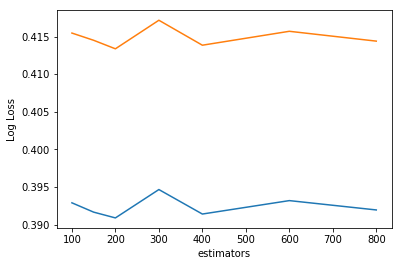

In [20]:
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = RFC(n_estimators=i,max_depth=11,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators') 
plt.ylabel('Log Loss')

<h2> 4.7 XGBoost </h2>

In [6]:
import xgboost as xgb

estimators =  100 Train Log Loss  0.3583641938531458 Test Log Loss  0.35961819366299197
estimators =  150 Train Log Loss  0.34716821707657336 Test Log Loss  0.3493991268629394
estimators =  200 Train Log Loss  0.339620979084566 Test Log Loss  0.34292007832953664
estimators =  300 Train Log Loss  0.3301188189311435 Test Log Loss  0.3358950724784673
estimators =  400 Train Log Loss  0.32337384734119523 Test Log Loss  0.33159850014983644
estimators =  600 Train Log Loss  0.3130198865512778 Test Log Loss  0.32630453308630486
estimators =  800 Train Log Loss  0.30483396799846996 Test Log Loss  0.3230216993976186


Text(0,0.5,'Log Loss')

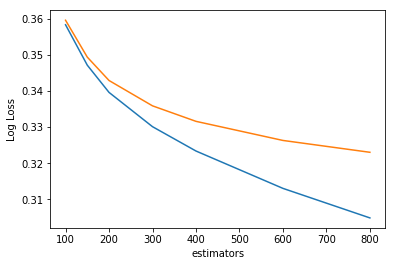

In [21]:
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in depths:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

Learning Rate =  0.05 Train Log Loss  0.3431145884649425 Test Log Loss  0.34599386091965273
Learning Rate =  0.1 Train Log Loss  0.3264772174456944 Test Log Loss  0.3333956069010313
Learning Rate =  0.15 Train Log Loss  0.31652482578279084 Test Log Loss  0.3278496386770277
Learning Rate =  0.2 Train Log Loss  0.3094281555236832 Test Log Loss  0.32583108629355173
Learning Rate =  0.25 Train Log Loss  0.30336320048274407 Test Log Loss  0.3243467612783949
Learning Rate =  0.3 Train Log Loss  0.2974955443733094 Test Log Loss  0.3225233032247901


Text(0,0.5,'Log Loss')

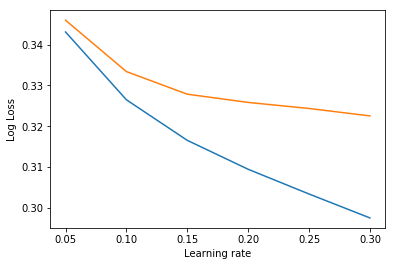

In [47]:
test_scores = []
train_scores = []
etas = [0.05,0.1,0.15,0.2,0.25,0.3]
for i in etas:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=i,n_estimators=350,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Learning Rate = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(etas,train_scores,label='Train Log Loss')
plt.plot(etas,test_scores,label='Test Log Loss')
plt.xlabel('Learning rate')
plt.ylabel('Log Loss')

reg_alpha =  0.5 Train Log Loss  0.26852223284338356 Test Log Loss  0.3312034872387728
reg_alpha =  1 Train Log Loss  0.26735883582307046 Test Log Loss  0.33056092032224055
reg_alpha =  5 Train Log Loss  0.2689006319588199 Test Log Loss  0.3292621067563762
reg_alpha =  10 Train Log Loss  0.27068857032690075 Test Log Loss  0.327132773020531
reg_alpha =  50 Train Log Loss  0.27974802262650905 Test Log Loss  0.3239947646462191
reg_alpha =  100 Train Log Loss  0.29039765847245264 Test Log Loss  0.32466225063664067
reg_alpha =  150 Train Log Loss  0.29908412709272575 Test Log Loss  0.3264270224443026


Text(0,0.5,'Log Loss')

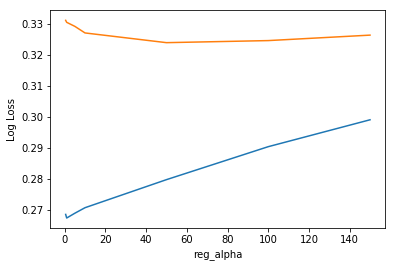

In [19]:
test_scores = []
train_scores = []
alpha = [0.5,1,5,10,50,100,150]
for i in alpha:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.65,n_estimators=370,reg_alpha=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('reg_alpha = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(alpha,train_scores,label='Train Log Loss')
plt.plot(alpha,test_scores,label='Test Log Loss')
plt.xlabel('reg_alpha')
plt.ylabel('Log Loss')

The test log loss is: 0.3663235114698256


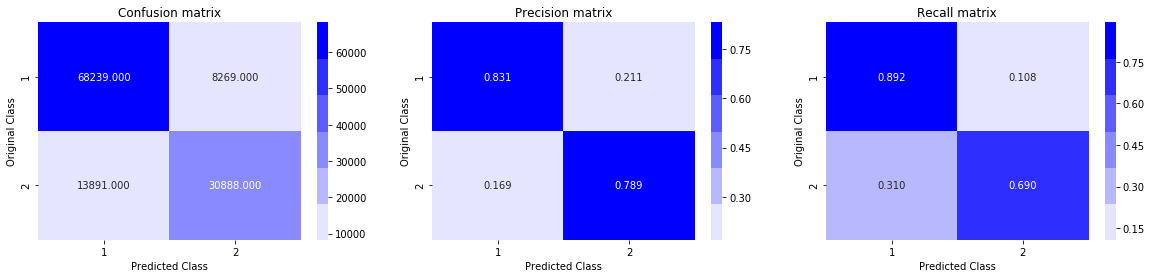

In [18]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.02,n_estimators=400,n_jobs=-1)
clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

Sampled data and did further hyperparam truning because of time constraints. random search for 15 models took around one day and then my system is not responding.

In [7]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [8]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [9]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)

In [10]:
y_true = list(map(int, y_true.values))

In [11]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3,random_state=13)

In [12]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


estimators =  100 Train Log Loss  0.3548561992467385 Test Log Loss  0.3627878957743776
estimators =  150 Train Log Loss  0.3419396997944057 Test Log Loss  0.35407105466366096
estimators =  200 Train Log Loss  0.3318797377522653 Test Log Loss  0.34891807315988954
estimators =  300 Train Log Loss  0.3168242151591801 Test Log Loss  0.343288478096738
estimators =  400 Train Log Loss  0.30455667545383736 Test Log Loss  0.33974266566115263
estimators =  600 Train Log Loss  0.283669436630139 Test Log Loss  0.3359795288017877
estimators =  800 Train Log Loss  0.26592577978587245 Test Log Loss  0.3345965160762109


Text(0,0.5,'Log Loss')

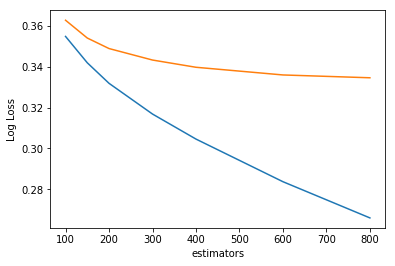

In [25]:
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

Learning Rate =  0.05 Train Log Loss  0.3486359981449816 Test Log Loss  0.3585428590734305
Learning Rate =  0.1 Train Log Loss  0.323761992687137 Test Log Loss  0.34551035487138326
Learning Rate =  0.15 Train Log Loss  0.30719720409078277 Test Log Loss  0.3405323742802464
Learning Rate =  0.2 Train Log Loss  0.2930345805370733 Test Log Loss  0.3385715798192348
Learning Rate =  0.25 Train Log Loss  0.2815342555628434 Test Log Loss  0.33910280387596653
Learning Rate =  0.3 Train Log Loss  0.27105970680499414 Test Log Loss  0.34047511766321725


Text(0,0.5,'Log Loss')

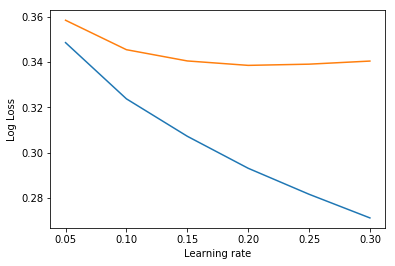

In [26]:
test_scores = []
train_scores = []
etas = [0.05,0.1,0.15,0.2,0.25,0.3]
for i in etas:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=i,n_estimators=250,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Learning Rate = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(etas,train_scores,label='Train Log Loss')
plt.plot(etas,test_scores,label='Test Log Loss')
plt.xlabel('Learning rate')
plt.ylabel('Log Loss')

reg_alpha =  0.5 Train Log Loss  0.18552754110016914 Test Log Loss  0.41771510824008634
reg_alpha =  1 Train Log Loss  0.18708247507165138 Test Log Loss  0.42690521142320964
reg_alpha =  5 Train Log Loss  0.1889097248930446 Test Log Loss  0.4139238847946861
reg_alpha =  10 Train Log Loss  0.19732091498184656 Test Log Loss  0.4020169662291672
reg_alpha =  50 Train Log Loss  0.2404195343979278 Test Log Loss  0.364811240860891
reg_alpha =  100 Train Log Loss  0.3044636385472295 Test Log Loss  0.35583897909062384
reg_alpha =  150 Train Log Loss  0.3439979601721529 Test Log Loss  0.36513114237933575


Text(0,0.5,'Log Loss')

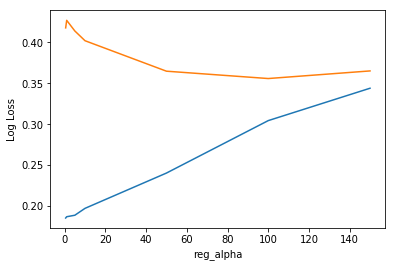

In [27]:
test_scores = []
train_scores = []
alpha = [0.5,1,5,10,50,100,150]
for i in alpha:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.95,n_estimators=250,reg_alpha=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('reg_alpha = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(alpha,train_scores,label='Train Log Loss')
plt.plot(alpha,test_scores,label='Test Log Loss')
plt.xlabel('reg_alpha')
plt.ylabel('Log Loss')

In [16]:
param_dist = {"max_depth": sp_randint(2,5),
              "learning_rate":uniform(0,0.2),
              "n_estimators":sp_randint(200,350),
              "min_child_weight": sp_randint(2, 8),
              "gamma": uniform(0,4),
              "subsample":uniform(0.7,0.3),
              "colsample_bytree": uniform(0.7,0.3),
              "reg_alpha":uniform(100,300),
              "reg_lambda":uniform(100,300)}

model_rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_dist,
                                   n_iter=30,scoring='neg_log_loss',cv=5,n_jobs=-1)
model_rs_xgb.fit(X_train,y_train)
pickle.dump(model_rs_xgb,open('model_rs_xgb.p','wb'))

In [23]:
dict_scores = []
idx = 0
for i in model_rs_xgb.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['n_estimators'])
    dict_score.append(i[0]['max_depth'])
    dict_score.append(i[0]['subsample'])
    dict_score.append(i[0]['min_child_weight'])
    dict_score.append(i[0]['learning_rate'])
    dict_score.append(i[0]['reg_alpha'])
    dict_score.append(i[0]['reg_lambda'])
    dict_score.append(i[0]['gamma'])
    dict_score.append(i[0]['colsample_bytree'])
    dict_score.append(-i[1])
    dict_score.append((np.abs(i[2]).std()))
    dict_score.append(-model_rs_xgb.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['n_estimators','depth','subsample','min_child_weight',
                                               'learning_rate','reg_alpha','reg_lambda','gamma',
                                               'colsample_bytree','Test_score',
                                               'Test_std','Train_score'])

In [24]:
scores_df.sort_values('Test_score').head(10)

,n_estimators,depth,subsample,min_child_weight,learning_rate,reg_alpha,reg_lambda,gamma,colsample_bytree,Test_score,Test_std,Train_score
21,312,4,0.862849,7,0.078998,151.329530,368.527334,2.475153,0.889555,0.365552,0.004887,0.355803
6,237,3,0.918557,7,0.093173,141.951036,247.381210,2.147542,0.959726,0.370005,0.005169,0.363034
2,252,4,0.861955,5,0.147171,211.574781,237.988483,1.297998,0.914696,0.371073,0.005258,0.363501
3,260,2,0.883727,5,0.162472,140.330037,125.075348,0.928819,0.723344,0.371593,0.004502,0.365183
1,263,3,0.989867,6,0.134493,201.904989,291.399625,1.215903,0.976700,0.374411,0.005102,0.368895
10,287,4,0.727813,3,0.083195,194.466489,393.672716,1.808000,0.963584,0.374655,0.005214,0.368341
0,335,4,0.836968,3,0.069301,215.509247,341.789604,2.932693,0.905324,0.375133,0.004916,0.369223
28,324,3,0.982237,3,0.060558,205.901274,176.926146,3.485774,0.748520,0.376651,0.004448,0.371700
26,257,3,0.737091,3,0.094935,183.424671,264.413431,1.303816,0.824543,0.377248,0.005051,0.372042
13,211,3,0.743472,7,0.082667,159.094695,283.155601,3.633829,0.982659,0.379051,0.004702,0.374420


The test log loss is: 0.362546103674608


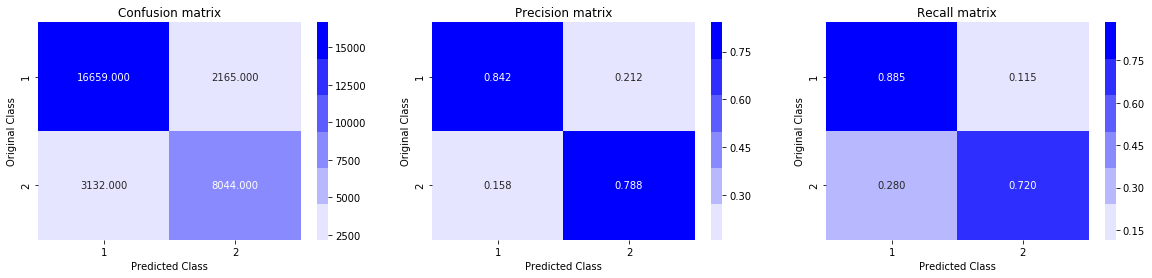

In [27]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=4,learning_rate=0.078998,n_estimators=312,
                        min_child_weight=7,subsample=0.862849,
                        reg_alpha=151.329530,reg_lambda=368.527334,
                        colsample_bytree=0.889555,gamma=2.475153,n_jobs=-1)
clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

### With Tf-Idf features

In [22]:
data.columns[0:26]

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [23]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [24]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [25]:
df1.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [26]:
df2.columns

Index(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [27]:
df3.columns

Index(['id', 'question1', 'question2'], dtype='object')

so for Tf-Idf Features i am combining question1 and question2, then getting Tf-Idf for for Train and transforming test.

In [28]:
df3 = df3.fillna(' ')
df4 = pd.DataFrame()
df4['Text'] = df3.question1 + ' ' + df3.question2
df4['id'] = df3.id

#### Combining question1 and question2, then getting Tf-Idf 

In [29]:
df2['id']=df1['id']
df4['id']=df1['id']
df5  = df1.merge(df2, on='id',how='left')
final  = df5.merge(df4, on='id',how='left')

In [30]:
final.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'Text'],
      dtype='object')

In [31]:
final = final.drop('id',axis=1)

In [32]:
X_train_tf,X_test_tf, y_train_tf, y_test_tf = train_test_split(final,duplicate, stratify=y_true, test_size=0.3,random_state=13)

In [33]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,3),max_features=200000,min_df=0.000032)
train_tfidf = tfidf_vect.fit_transform(X_train_tf.Text)
test_tfidf = tfidf_vect.transform(X_test_tf.Text)
print('No of Tfidf features',len(tfidf_vect.get_feature_names()))

No of Tfidf features 122967


In [34]:
X_train_tf = X_train_tf.drop('Text',axis=1)
X_test_tf = X_test_tf.drop('Text',axis=1)

In [35]:
from scipy.sparse import hstack
X_train1 = hstack((X_train_tf.values,train_tfidf))
X_test1 = hstack((X_test_tf.values,test_tfidf))

In [36]:
X_train1

<283003x122993 sparse matrix of type '<class 'numpy.float64'>'
	with 16070821 stored elements in COOrdinate format>

In [37]:
scale = StandardScaler(with_mean=False)
X_train_sc = scale.fit_transform(X_train1)
X_test_sc = scale.transform(X_test1)

For values of alpha =  1e-05 The log loss is: 0.43314008705729606
For values of alpha =  0.0001 The log loss is: 0.4331272796939656
For values of alpha =  0.001 The log loss is: 0.4327302472283095
For values of alpha =  0.01 The log loss is: 0.4283776670722629
For values of alpha =  0.1 The log loss is: 0.3881322803856421
For values of alpha =  1 The log loss is: 0.40257550672626424
For values of alpha =  10 The log loss is: 0.4613941629266127


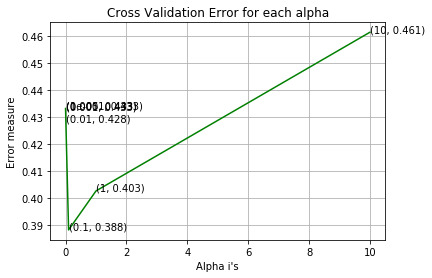

For values of best alpha =  0.1 The train log loss is: 0.26985162323505474
For values of best alpha =  0.1 The test log loss is: 0.3881322803856421
Total number of data points : 121287


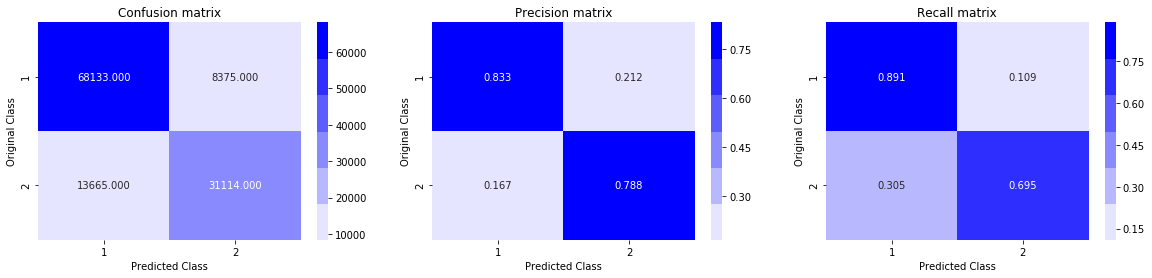

In [180]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  0.0795 The log loss is: 0.39064417583295863
For values of alpha =  0.0879 The log loss is: 0.3894558074210688
For values of alpha =  0.116 The log loss is: 0.3869327250039135
For values of alpha =  0.1481 The log loss is: 0.38565275085466144
For values of alpha =  0.1612 The log loss is: 0.3854195068372494
For values of alpha =  0.2439 The log loss is: 0.3856745506873943
For values of alpha =  0.2538 The log loss is: 0.38581966177962984
For values of alpha =  0.2633 The log loss is: 0.3859735181868948
For values of alpha =  0.27 The log loss is: 0.38608826320451
For values of alpha =  0.2905 The log loss is: 0.38646998649269443
For values of alpha =  0.3092 The log loss is: 0.3868477094820089
For values of alpha =  0.3229 The log loss is: 0.387144248260163
For values of alpha =  0.4396 The log loss is: 0.389928810977827
For values of alpha =  0.441 The log loss is: 0.389963612599141


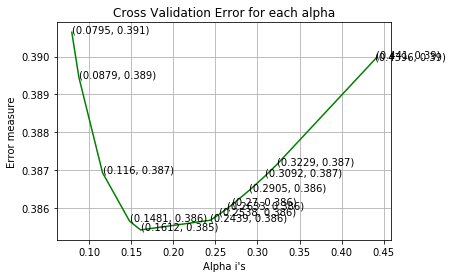

For values of best alpha =  0.1612 The train log loss is: 0.2749225188463317
For values of best alpha =  0.1612 The test log loss is: 0.3854195068372494
Total number of data points : 121287


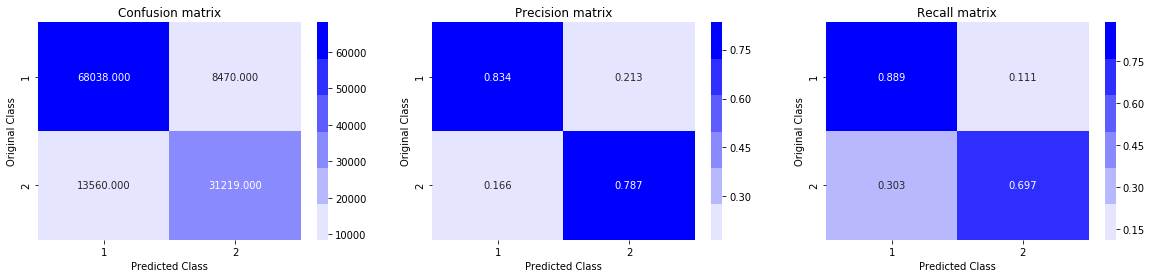

In [182]:
#alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
alpha = np.random.uniform(0.05,0.5,14)
alpha = np.round(alpha,4)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

it was giving some good scores but it seems to be some overfitting in this.  
i think it may be because of feature scaling for all the data including tfidf values so i tried without feature scaling

For values of alpha =  1e-05 The log loss is: 0.45919822041900693
For values of alpha =  0.0001 The log loss is: 0.4663672071140698
For values of alpha =  0.001 The log loss is: 0.4492402172589541
For values of alpha =  0.01 The log loss is: 0.44994060193898233
For values of alpha =  0.1 The log loss is: 0.46275295853045256
For values of alpha =  1 The log loss is: 0.4939560730721335
For values of alpha =  10 The log loss is: 0.5434258589612511


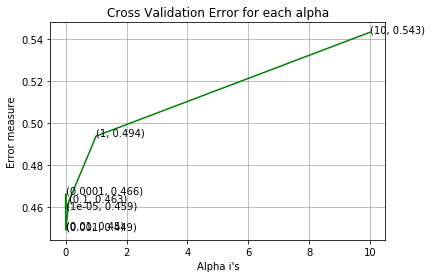

For values of best alpha =  0.001 The train log loss is: 0.4489866787327462
For values of best alpha =  0.001 The test log loss is: 0.4492402172589541
Total number of data points : 121287


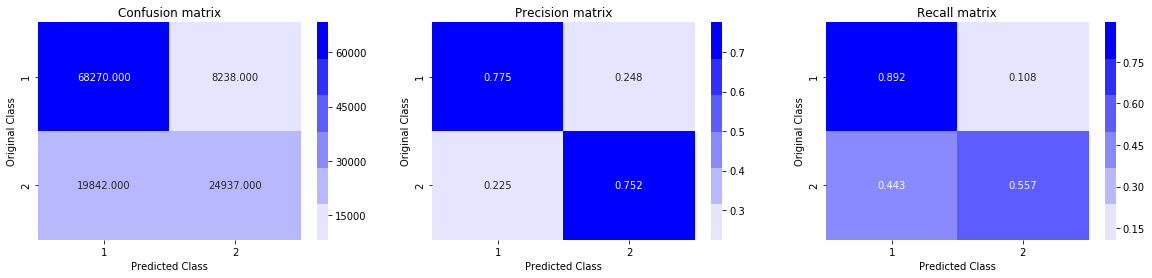

In [183]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train)
    predict_y = sig_clf.predict_proba(X_test1)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train)

predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

i decresed overfittig but bias increased.
Tought like i will scale features otherthan Tf-Idf and Tf-Idf was already coming with l2 normalization. so tried with this format below

In [38]:
scale = StandardScaler()
X_train_some = scale.fit_transform(X_train_tf)
X_test_some = scale.transform(X_test_tf)

In [39]:
from scipy.sparse import hstack
X_train2 = hstack((X_train_some,train_tfidf))
X_test2 = hstack((X_test_some,test_tfidf))

For values of alpha =  1e-05 The log loss is: 0.3592485420041076
For values of alpha =  0.0001 The log loss is: 0.38220592755894905
For values of alpha =  0.001 The log loss is: 0.4040174130069092
For values of alpha =  0.01 The log loss is: 0.4228198041131542
For values of alpha =  0.1 The log loss is: 0.4598042497583823
For values of alpha =  1 The log loss is: 0.5086852562507405
For values of alpha =  10 The log loss is: 0.534388446481064


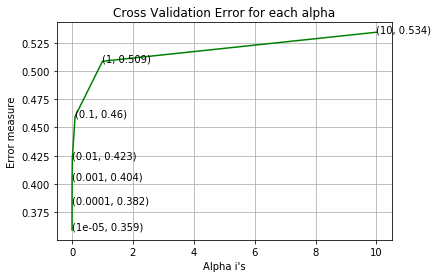

For values of best alpha =  1e-05 The train log loss is: 0.3395431324943519
For values of best alpha =  1e-05 The test log loss is: 0.3592485420041076
Total number of data points : 121287


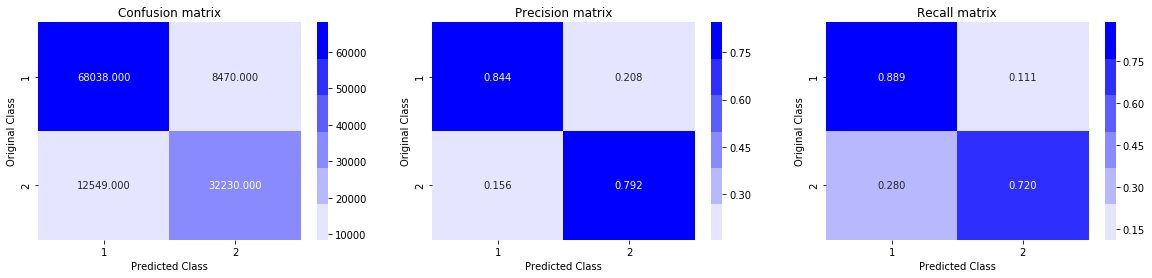

In [193]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train2, y_train)
    predict_y = sig_clf.predict_proba(X_test2)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train2, y_train)

predict_y = sig_clf.predict_proba(X_train2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Now it seems to be good 

For values of alpha =  4.13e-06 The log loss is: 0.36122866843967544
For values of alpha =  5.47e-06 The log loss is: 0.3588790251668011
For values of alpha =  7.73e-06 The log loss is: 0.3584450374617226
For values of alpha =  8.84e-06 The log loss is: 0.3588864116809375
For values of alpha =  9.38e-06 The log loss is: 0.3590125699678223
For values of alpha =  1.143e-05 The log loss is: 0.35994931400868724
For values of alpha =  1.583e-05 The log loss is: 0.3624907902604967
For values of alpha =  1.628e-05 The log loss is: 0.3626844556970233
For values of alpha =  1.782e-05 The log loss is: 0.36357454612123535
For values of alpha =  1.914e-05 The log loss is: 0.3641980673263202
For values of alpha =  2.192e-05 The log loss is: 0.36554921230584847
For values of alpha =  2.659e-05 The log loss is: 0.3674344684859557
For values of alpha =  2.69e-05 The log loss is: 0.3675203002315432
For values of alpha =  2.832e-05 The log loss is: 0.3680707978055651


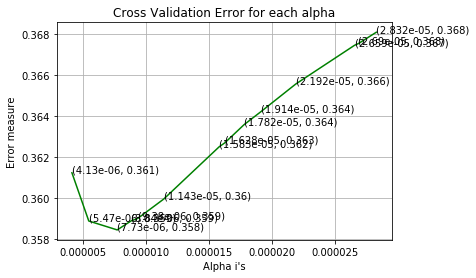

For values of best alpha =  7.73e-06 The train log loss is: 0.3368825243663587
For values of best alpha =  7.73e-06 The test log loss is: 0.3584450374617226
Total number of data points : 121287


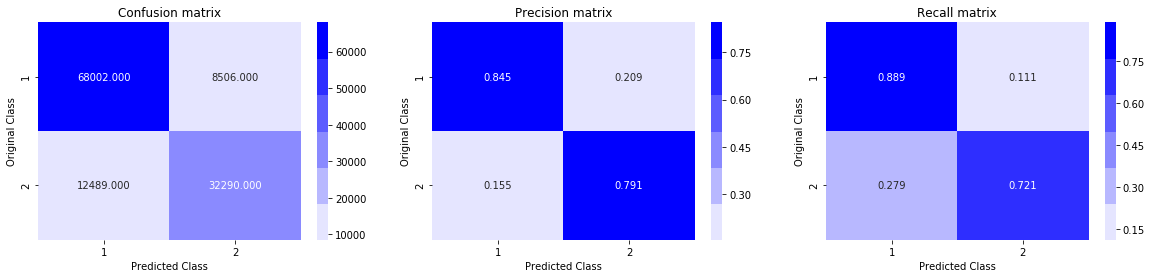

In [40]:
#alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
alpha = np.random.uniform(0.000002,0.00003,14)
alpha = np.round(alpha,8)
alpha.sort()

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train2, y_train)
    predict_y = sig_clf.predict_proba(X_test2)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train2, y_train)

predict_y = sig_clf.predict_proba(X_train2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [15]:
X_train_w2v = X_train.drop(scale_col,axis=1)
X_test_w2v = X_test.drop(scale_col,axis=1)

### Logistic Regression:

For values of alpha =  1e-05 The log loss is: 0.4388024128087525
For values of alpha =  0.0001 The log loss is: 0.39289765345196564
For values of alpha =  0.001 The log loss is: 0.3884671083090384
For values of alpha =  0.01 The log loss is: 0.4036735395413484
For values of alpha =  0.1 The log loss is: 0.4488595248965405
For values of alpha =  1 The log loss is: 0.4991565448915637
For values of alpha =  10 The log loss is: 0.5276589765281985


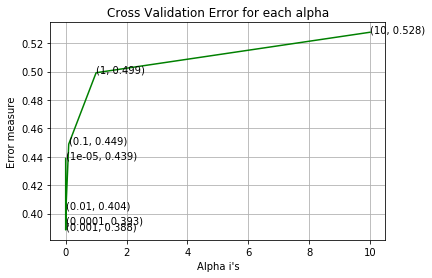

For values of best alpha =  0.001 The train log loss is: 0.38681517329784765
For values of best alpha =  0.001 The test log loss is: 0.3884671083090384
Total number of data points : 121287


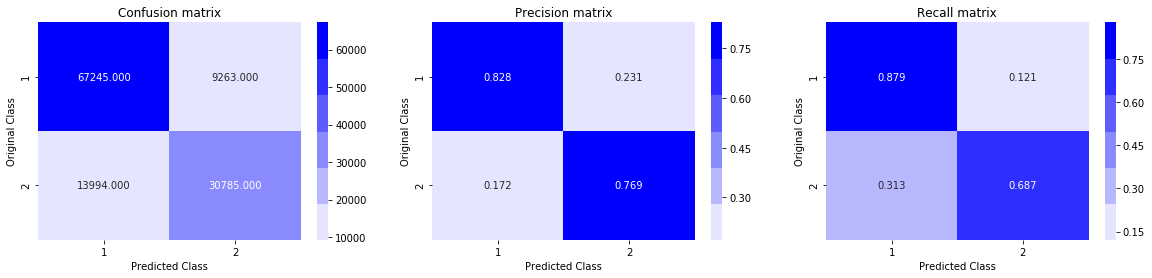

In [103]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_fi, y_train)
    predict_y = sig_clf.predict_proba(X_test_fi)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_fi, y_train)

predict_y = sig_clf.predict_proba(X_train_fi)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_fi)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  0.00081 The log loss is: 0.38825354941894474
For values of alpha =  0.000835 The log loss is: 0.3882756602391445
For values of alpha =  0.001092 The log loss is: 0.3885959531928289
For values of alpha =  0.001711 The log loss is: 0.3896869070388385
For values of alpha =  0.00275 The log loss is: 0.3917852442253969
For values of alpha =  0.002811 The log loss is: 0.39189532200667276
For values of alpha =  0.00283 The log loss is: 0.39193474315728954
For values of alpha =  0.003226 The log loss is: 0.39271932002087345
For values of alpha =  0.00347 The log loss is: 0.3932148339643286
For values of alpha =  0.004055 The log loss is: 0.39433385702572826
For values of alpha =  0.004436 The log loss is: 0.3950361601874909
For values of alpha =  0.004509 The log loss is: 0.3951700685766183
For values of alpha =  0.004863 The log loss is: 0.39583426043986775
For values of alpha =  0.004939 The log loss is: 0.39596458548444097


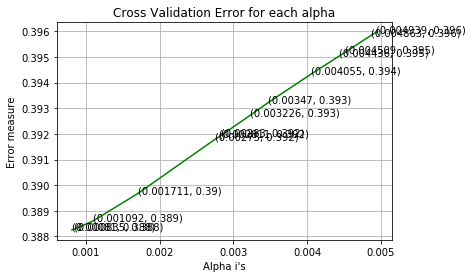

For values of best alpha =  0.00081 The train log loss is: 0.3865499173703697
For values of best alpha =  0.00081 The test log loss is: 0.38825354941894474
Total number of data points : 121287


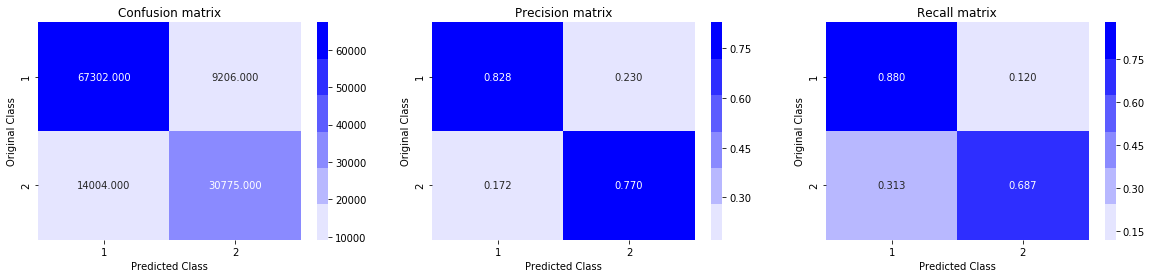

In [104]:
#alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

alpha = np.random.uniform(0.0005,0.005,14)
alpha = np.round(alpha,6)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_fi, y_train)
    predict_y = sig_clf.predict_proba(X_test_fi)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_fi, y_train)

predict_y = sig_clf.predict_proba(X_train_fi)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_fi)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)